# Comparative Analysis of Ensemble Methods for Predicting Antibody Titers

Author: Elias Dams

Date: 2 Dec 2024

Implement and Compare Ensemble Methods:
- Apply different ensemble learning techniques to predict antibody titers.
- Evaluate the performance of each method on individual datasets.
Identify the Best Predictive Model:
- Determine which method or combination of methods provides the highest accuracy.
- Assess whether integrating multiple data types improves predictions.

### Methods Overview
#### 1. Consensus Between Different Models
Description: Combine predictions from multiple models to reach a consensus decision. This can be achieved through techniques like majority voting for classification or averaging for regression tasks.
Purpose: To reduce individual model biases and variance by aggregating multiple model outputs, potentially leading to improved generalization on unseen data.

#### 2. Stacking Classifiers
Description: An ensemble technique where multiple base classifiers are trained, and a meta-classifier is then trained on their outputs to make the final prediction.
Purpose: To leverage the strengths of various algorithms by combining their predictions in a way that the meta-classifier can correct their individual weaknesses.

#### 3. Cascading Models:
Description: Sequentially apply models where the output of one model serves as the input for the next. This approach can be thought of as creating a pipeline of models that refine predictions progressively.
Purpose: To capture complex patterns by allowing subsequent models to learn from the residuals or errors of previous models, enhancing overall predictive capability.

#### 4. Multiple Kernel Learning
Description: An extension of kernel-based algorithms (e.g., Support Vector Machines) that utilizes multiple kernel functions to handle heterogeneous data sources. Each kernel can capture different data characteristics.
Purpose: To effectively integrate and learn from diverse data types by optimizing the combination of kernels, thereby improving model performance on complex datasets.



In [55]:
from mlxtend.evaluate import scoring
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from statsmodels.tools.sequences import primes_from_2_to
from tqdm import tqdm
from scipy.stats import mode
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import resample, shuffle
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.base import clone
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer, balanced_accuracy_score
from sklearn.impute import SimpleImputer, KNNImputer

In [56]:
# Load the antibody titers data (response profile)
abtiters = pd.read_csv('../data/antibody_df.csv')
print("Antibody titers data loaded. Shape:", abtiters.shape)
print(abtiters.head())

# Load the cytokines data
cytokines = pd.read_csv('../data/cytokines_data.csv')
print("Cytokines data loaded. Shape:", cytokines.shape)
print(cytokines.head())

# Load the cytometry data
cytometry = pd.read_csv('../data/cyto_data.csv')
print("Cytometry data loaded. Shape:", cytometry.shape)
print(cytometry.head())

# Load clonal breadth data
clonal_breadth = pd.read_csv('../data/clonal_breadth_data.csv')
print("Clonal breadth data loaded. Shape:", clonal_breadth.shape)
print(clonal_breadth.head())
# How many different TCR clonotypes (unique combinations of sequences, V/J genes, etc.) are specific to measles.

# Load clonal depth data
clonal_depth = pd.read_csv('../data/clonal_depth_data.csv')
print("Clonal depth data loaded. Shape:", clonal_depth.shape)
print(clonal_depth.head())
# The ratio of unique beta-chain sequences predicted to bind measles to the total number of clonotypes. 
# This focuses on the most important part of the TCR (the beta chain).

# Load the module scores
module_scores = pd.read_csv('../data/module_scores_model_input_all.csv') #calculate for Hepatitis B data
print("Module scores loaded. Shape:", module_scores.shape)
print(module_scores.head())

# Check the distribution of module scores
print("Module score columns:", module_scores.columns[1:10])

datasets = {
    "antibody_titers": abtiters,
    "cytokines": cytokines,
    "cytometry": cytometry,
    "clonal_breadth": clonal_breadth,
    "clonal_depth": clonal_depth,
    "RNa_data": module_scores,
}

Antibody titers data loaded. Shape: (40, 12)
        vaccine Vaccinee     Day 0    Day 21   Day 150   Day 365  diff: 21-0  \
0  Anti-Measles       M1   5.00000 217.00000  30.80000  31.50000   212.00000   
1  Anti-Measles      M11  17.90000  30.10000 300.00000 214.00000    12.20000   
2  Anti-Measles      M12 300.00000 300.00000 300.00000 300.00000     0.00000   
3  Anti-Measles      M13 227.00000 300.00000 236.00000 300.00000    73.00000   
4  Anti-Measles      M14  26.70000 261.00000 276.00000 300.00000   234.30000   

   diff: 150-21  diff: 365-150  response  protected               quadrant  
0    -186.20000        0.70000      True       True              responder  
1     269.90000      -86.00000     False      False   no response - low ab  
2       0.00000        0.00000     False       True  no response - high ab  
3     -64.00000       64.00000     False       True  no response - high ab  
4      15.00000       24.00000      True       True              responder  
Cytokines da


Frequency of responses:
response_label
no response    29
response       11
Name: count, dtype: int64


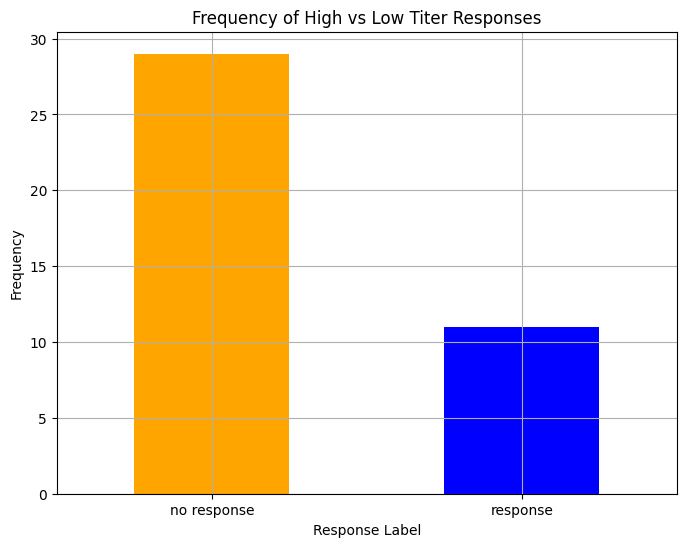

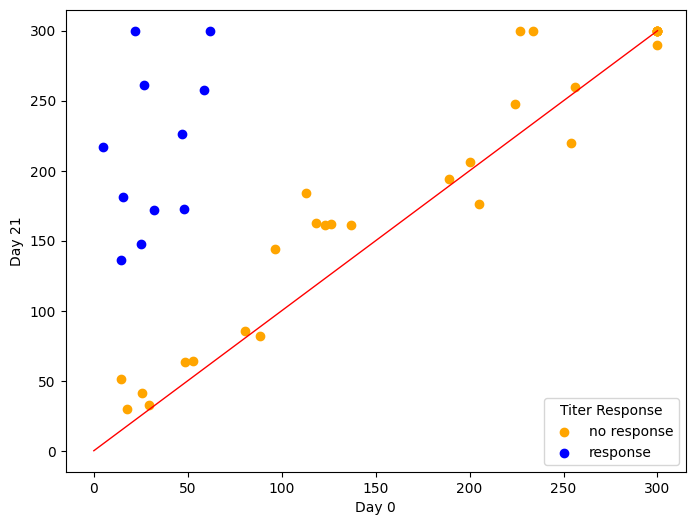

In [57]:
# Count the frequency of each label
abtiters['response_label'] = abtiters['quadrant'].apply(lambda x: 'response' if x == 'responder' else 'no response')

# Count the frequency of each label
response_counts = abtiters['response_label'].value_counts()

print("\nFrequency of responses:")
print(response_counts)

# Plot the frequency of high vs. low responses as a bar plot
plt.figure(figsize=(8, 6))
response_counts.plot(kind='bar', color=['orange', 'blue'])
plt.title('Frequency of High vs Low Titer Responses')
plt.xlabel('Response Label')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

colors = {'response': 'blue', 'no response': 'orange'}
plt.figure(figsize=(8, 6))
for label, group in abtiters.groupby('response_label'):
    plt.scatter(group['Day 0'], group['Day 21'], color=colors[label], label=label)

# Plot reference line y = x
plt.plot([0, max(abtiters['Day 0'])], [0, max(abtiters['Day 21'])], color='red', linestyle='-', linewidth=1)

# Labeling and legend
plt.xlabel('Day 0')
plt.ylabel('Day 21')
plt.legend(title="Titer Response")
plt.show()

In [58]:
abtiters = abtiters.drop(columns=['vaccine', 'Day 0', 'Day 21', 'Day 150', 'Day 365', 'diff: 21-0', 'diff: 150-21', 'diff: 365-150', 'response', 'protected','quadrant'])
## cytokines already loaded ##
cytometry = cytometry[['Vaccinee', 'WBC Day 0','RBC Day 0','HGB Day 0','HCT Day 0','PLT Day 0','%LYM Day 0','%MON Day 0','%GRA Day 0']]

datasets['antibody_titers'] = abtiters
datasets['cytometry'] = cytometry

### calculate a module score and comapare

In [59]:
def create_RNa_module_scores(read_count_path, module_scores_path, output_path_path):

    # Load data
    read_counts = pd.read_csv(read_count_path, index_col=0)  # Patients as rows, genes as columns
    module_list = pd.read_csv(module_scores_path)  # Contains columns 'Module', 'Gene', 'Function'
    
    # Ensure columns are strings for consistency
    read_counts.columns = read_counts.columns.astype(str)
    
    module_scores = []

    for module in module_list['Module'].unique():
        # Get the module's function
        module_function = module_list.loc[module_list['Module'] == module, 'Function'].iloc[0]
        module_genes = module_list[module_list['Module'] == module]['Gene']
        common_genes = [gene for gene in module_genes if gene in read_counts.columns]
    
        if not common_genes:
            print(f"No overlapping genes found for module {module}. Skipping.")
            continue
    
        # Subset read_counts for the genes in this module
        module_data = read_counts[common_genes]
        
        # Standardize the data
        scaler = StandardScaler()
        standardized_data = scaler.fit_transform(module_data)
        
        # Perform 1D PCA
        pca = PCA(n_components=1)
        pca_scores = pca.fit_transform(standardized_data)
        
        # Store results with module name and function
        module_scores.append(pd.DataFrame(
            pca_scores,
            index=read_counts.index,
            columns=[f"{module}.{module_function}"]
        ))
    
    # Combine all module scores into a single DataFrame
    module_scores_df = pd.concat(module_scores, axis=1)
    module_scores_df = module_scores_df.copy()
    
    # ---- pivoting logic -----
    
    # Extract 'Vaccinee' and 'TimePoint' from the index
    module_scores_df['TimePoint'] = module_scores_df.index.str.extract(r'_EXP(\d+)$', expand=False)
    module_scores_df['Vaccinee'] = module_scores_df.index.str.replace(r'_EXP\d+$', '', regex=True)
    
    # Reshape the data from long to wide format
    module_scores_df.reset_index(drop=True, inplace=True)  # Remove the old index
    wide_format = module_scores_df.pivot(index='Vaccinee', columns='TimePoint')
    
    # Flatten the MultiIndex in columns
    wide_format.columns = [
        f"{col[0]}_EXP{col[1]}" for col in wide_format.columns
    ]
    
    # Reset index to make 'Vaccinee' a column
    wide_format.reset_index(inplace=True)
    
    # Save the transformed data
    wide_format.to_csv(output_path_path, index=False)
    print(f"Transformed data saved as '{output_path_path}'")

In [60]:
create_RNa_module_scores(read_count_path = "../data/processed_readcounts_collapsed.csv", 
                         module_scores_path= "../data/module_list.csv", 
                         output_path_path= "../data_created/module_scores_model_input_all_self_made.csv")

rna_data = pd.read_csv("../data_created/module_scores_model_input_all_self_made.csv")
datasets["RNa_data"] = rna_data

Transformed data saved as '../data_created/module_scores_model_input_all_self_made.csv'


### 1. Consensus Between Different Models

In [61]:
# Merge datasets with the labels
cytokines_merged = pd.merge(datasets['antibody_titers'], datasets['cytokines'], on='Vaccinee')
cytometry_merged = pd.merge(datasets['antibody_titers'], datasets['cytometry'], on='Vaccinee')
clonal_breadth_merged = pd.merge(datasets['antibody_titers'], datasets['clonal_breadth'], on='Vaccinee') #for now because they only contain 27 values
clonal_depth_merged = pd.merge(datasets['antibody_titers'], datasets['clonal_depth'], on='Vaccinee') #for now because they only contain 27 values
rna_merged = pd.merge(datasets['antibody_titers'], datasets['RNa_data'], on='Vaccinee')

In [62]:
# Function to check missing values
def check_missing_values(df, dataset_name):
    nr_samples = len(datasets['antibody_titers']['Vaccinee'])
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    
    print(f"{dataset_name}:")
    
    if len(df['Vaccinee']) < nr_samples:
        print(f"\tMissing samples: only contains {len(df['Vaccinee'])} samples instead of {nr_samples}.") 
        
    
    if not missing.empty:
        print(f"\tMissing values:")
        print(f"\t{missing}")
    else:
        print(f"\tNo missing values.")

# Check for missing values
check_missing_values(cytokines_merged, 'Cytokines Merged')
check_missing_values(cytometry_merged, 'Cytometry Merged')
check_missing_values(clonal_breadth_merged, 'Clonal Breadth Merged')
check_missing_values(clonal_depth_merged, 'Clonal Depth Merged')
check_missing_values(rna_merged, 'RNA Merged')

Cytokines Merged:
	No missing values.
Cytometry Merged:
	No missing values.
Clonal Breadth Merged:
	Missing samples: only contains 27 samples instead of 40.
	No missing values.
Clonal Depth Merged:
	Missing samples: only contains 27 samples instead of 40.
	No missing values.
RNA Merged:
	No missing values.


In [63]:
def handle_missing_values(df, dataset_name, complete_samples, strategy='mean'):
    print(f"Handling missing values for {dataset_name}...")
    new_df = df.copy()

    # Identify missing samples
    missing_samples = complete_samples[~complete_samples['Vaccinee'].isin(df['Vaccinee'])]
    if missing_samples.empty:
        print(f"\tNo missing samples to add for {dataset_name}.")
        return new_df

    print(f"\tFound {len(missing_samples)} missing samples to process.")

    # Function to prepare training subset
    def prepare_training_subset(label, df):
        if pd.notnull(label):
            subset = df[df['response_label'] == label].drop(['Vaccinee', 'response_label'], axis=1)
            return subset if not subset.empty else df.drop(['Vaccinee', 'response_label'], axis=1)
        return df.drop(['Vaccinee', 'response_label'], axis=1)

    # Imputation logic
    imputed_features_list = []
    imputer_class = KNNImputer if strategy.lower() == 'knn' else SimpleImputer
    imputer_kwargs = {'strategy': strategy} if strategy.lower() != 'knn' else {'n_neighbors': 3}

    for label, group in missing_samples.groupby('response_label'):
        # Prepare training subset
        train_subset = prepare_training_subset(label, df)
        
        # Ensure all columns in train_subset exist in the group
        features = group[['Vaccinee', 'response_label']].copy()  # Keep 'Vaccinee' and 'response_label' intact
        for col in train_subset.columns:
            if col not in features.columns:
                features[col] = None  # Add missing columns with None
        
        # Drop 'Vaccinee' and 'response_label' for imputation
        imputation_input = features.drop(['Vaccinee', 'response_label'], axis=1)
        
        # Impute missing values
        imputer = imputer_class(**imputer_kwargs)
        imputer.fit(train_subset)
        imputed_values = imputer.transform(imputation_input)
        
        # Add imputed values back to the features DataFrame
        for i, col in enumerate(imputation_input.columns):
            features[col] = imputed_values[:, i]
        
        imputed_features_list.append(features)

    # Combine all imputed groups
    imputed_features = pd.concat(imputed_features_list, axis=0).reset_index(drop=True)

    # Append imputed samples to the original dataframe
    new_df = pd.concat([df, imputed_features], ignore_index=True)
    new_df = new_df.set_index('Vaccinee').reindex(complete_samples['Vaccinee']).reset_index()
    print(f"\tAdded {len(imputed_features)} samples to {dataset_name}.")

    return new_df

cytokines_merged = handle_missing_values(cytokines_merged, 'Cytokines Merged', datasets['antibody_titers'], strategy='mean')
cytometry_merged = handle_missing_values(cytometry_merged, 'Cytometry Merged', datasets['antibody_titers'], strategy='mean')
clonal_breadth_merged =handle_missing_values(clonal_breadth_merged, 'Clonal Breadth Merged', datasets['antibody_titers'], strategy='mean')
clonal_depth_merged = handle_missing_values(clonal_depth_merged, 'Clonal Depth Merged', datasets['antibody_titers'], strategy='mean')
rna_merged = handle_missing_values(rna_merged, 'RNA Merged', datasets['antibody_titers'], strategy='mean')

Handling missing values for Cytokines Merged...
	No missing samples to add for Cytokines Merged.
Handling missing values for Cytometry Merged...
	No missing samples to add for Cytometry Merged.
Handling missing values for Clonal Breadth Merged...
	Found 13 missing samples to process.
	Added 13 samples to Clonal Breadth Merged.
Handling missing values for Clonal Depth Merged...
	Found 13 missing samples to process.
	Added 13 samples to Clonal Depth Merged.
Handling missing values for RNA Merged...
	No missing samples to add for RNA Merged.


In [64]:
def compress_correlated_features(data, groups):
    """
    Compress groups of highly correlated features into a single principal component for each group.
    
    Parameters:
    - data (pd.DataFrame): The input dataframe containing the features.
    - groups (dict): A dictionary where keys are group names and values are lists of correlated features.
    
    Returns:
    - data (pd.DataFrame): The dataframe with compressed features added and original features removed.
    """
    def compress_features(data, features, new_feature_name):
        # Standardize the features
        scaler = StandardScaler()
        standardized_features = scaler.fit_transform(data[features])
        
        # Perform PCA to extract the first principal component
        pca = PCA(n_components=1)
        principal_component = pca.fit_transform(standardized_features)
        
        # Add the new compressed feature to the dataframe
        data[new_feature_name] = principal_component
        return data

    # Iterate over each group and compress the features
    for group_name, features in groups.items():
        new_feature_name = f"{group_name}_Compressed"
        data = compress_features(data, features, new_feature_name)

    # Drop the original features that were compressed
    all_features_to_drop = [feature for group in groups.values() for feature in group]
    data.drop(columns=all_features_to_drop, inplace=True)
    
    return data

compress = False
if compress:
    # Define the groups of correlated features cytokines
    cytokines_groups = {
        'Group_1': ['TNFb', 'IL-13', 'MCP3', 'IL1Ra'],
        'Group_2': ['IL-2', 'GM-CSF', 'IL-10', 'IL-9', 'IFNa2', 'IL-7'],
        'Group_3': ['TNFa', 'TGF-a', 'IL17A', 'IFNg', 'IL12-p70', 'MIP1b', 'FGF-2'], # 'Flt3 Ligand', 'VEGF'
        'Group_4': ['Fractalkine', 'IL-15', 'IL-1b' ]
    }
    
    cytokines_merged = compress_correlated_features(cytokines_merged, cytokines_groups)
    
    # Define the groups of correlated features cytokines
    cytometry_groups = {
        'Group_1': ['RBC Day 0', 'HGB Day 0', 'HCT Day 0'],
        'Group_2': ['%LYM Day 0', '%GRA Day 0']
    }
    
    cytometry_merged = compress_correlated_features(cytometry_merged, cytometry_groups)


In [65]:
def encode_labels(df):
    le = LabelEncoder()
    df['response_label'] = le.fit_transform(df['response_label'])
    return df

# Encode labels if necessary
cytokines_merged = encode_labels(cytokines_merged)
cytometry_merged = encode_labels(cytometry_merged)
clonal_breadth_merged = encode_labels(clonal_breadth_merged)
clonal_depth_merged = encode_labels(clonal_depth_merged)
rna_merged = encode_labels(rna_merged)

In [66]:
# Let's get the list of vaccinees to use as indices

balanced_test_set = False
if not balanced_test_set:
    # to just shiffle randomly
    vaccinees = abtiters['Vaccinee']
    train_vaccinees, test_vaccinees = train_test_split(vaccinees, test_size=0.2, random_state=42, stratify=abtiters['response_label'])
else:
    # Define the desired number of samples per class in the test set
    test_samples_per_class = 4  # 4 positive + 4 negative = 8 total
    
    # Separate positive and negative samples
    positive_samples = abtiters[abtiters['response_label'] == 'response']
    negative_samples = abtiters[abtiters['response_label'] == 'no response']
    
    # Ensure there are enough samples to meet the requirement
    assert len(positive_samples) >= test_samples_per_class, "Not enough positive samples for the test set"
    assert len(negative_samples) >= test_samples_per_class, "Not enough negative samples for the test set"
    
    # Randomly sample the test set for each class
    pos_test = positive_samples.sample(n=test_samples_per_class, random_state=42)
    neg_test = negative_samples.sample(n=test_samples_per_class, random_state=42)
    
    # Define the test set by combining positive and negative samples
    test_set = pd.concat([pos_test, neg_test])
    
    # Define the train set by excluding the test samples
    train_set = abtiters.drop(test_set.index)
    
    # Shuffle the train and test sets to ensure randomness
    train_set = train_set.sample(frac=1, random_state=42)
    test_set = test_set.sample(frac=1, random_state=42)
    
    train_vaccinees = pd.Series(train_set['Vaccinee'].values, index=train_set.index, name="Train Vaccinee")
    test_vaccinees = pd.Series(test_set['Vaccinee'].values, index=test_set.index, name="Test Vaccinee")
    
    # Print distributions for verification
    print("Train set distribution:")
    print(train_set['response_label'].value_counts())
    print("\nTest set distribution:")
    print(test_set['response_label'].value_counts())

def split_dataset(df, oversampling_method = None):
    # Use the pre-defined train and test vaccinees
    train_df = df[df['Vaccinee'].isin(train_vaccinees)]
    test_df = df[df['Vaccinee'].isin(test_vaccinees)]
    
    # Separate features and labels
    X_train = train_df.drop(['Vaccinee', 'response_label'], axis=1)
    y_train = train_df['response_label']
    X_test = test_df.drop(['Vaccinee', 'response_label'], axis=1)
    y_test = test_df['response_label']
    
    X_train_resampled = X_train
    y_train_resampled = y_train
    
    if oversampling_method is not None:
        if oversampling_method == 'smote':
            # Perform oversampling on the training data
            sm = SMOTE(random_state=42)
            X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
        
        elif oversampling_method == 'random':
            # Perform random oversampling on the training data (simply duplicates existing minority class samples)
            ros = RandomOverSampler(random_state=42)
            X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
        
        elif oversampling_method == 'remove':
            # Perform random undersampling on the majority class
            majority_class = Counter(y_train).most_common(1)[0][0]  # Get the majority class label
            minority_class = [cls for cls in set(y_train) if cls != majority_class][0]  # Get minority class label
            
            # Separate majority and minority classes
            X_majority = X_train[y_train == majority_class]
            y_majority = y_train[y_train == majority_class]
            X_minority = X_train[y_train == minority_class]
            y_minority = y_train[y_train == minority_class]
            
            # Downsample majority class to match minority class size
            X_majority_downsampled, y_majority_downsampled = resample(
                X_majority, y_majority,
                replace=False,
                n_samples=len(y_minority),
                random_state=42
            )
            
            # Identify the removed majority class samples
            # Use index to ensure accurate removal
            removed_indices = X_majority.index.difference(X_majority_downsampled.index)
            X_majority_removed = X_majority.loc[removed_indices]
            y_majority_removed = y_majority.loc[removed_indices]
            
            # Combine downsampled majority class with the minority class
            X_train_resampled = pd.concat([X_majority_downsampled, X_minority])
            y_train_resampled = pd.concat([y_majority_downsampled, y_minority])
            
            # Add the removed samples to the rest set
            # Concatenate features and labels for the rest set
            removed_samples = pd.concat([X_majority_removed, y_majority_removed], axis=1)
            X_rest = removed_samples.drop(['response_label'], axis=1)
            y_rest = removed_samples['response_label']
            X_test = pd.concat([X_test,X_rest])
            y_test = pd.concat([y_test,y_rest])
        
        else:
            raise ValueError(f"Unsupported oversampling method: {oversampling_method}")
    
        
                
        # After oversampling
        print(f"Resampled class distribution using {oversampling_method} for train set: {Counter(y_train_resampled)}")
        print(f"Resampled class distribution using {oversampling_method} for test set: {Counter(y_test)}")
    else:
        # No oversampling
        print(f"Class distribution for train set: {Counter(y_train_resampled)}")
        print(f"Class distribution for test set: {Counter(y_test)}")
    
        
    
    return X_train_resampled, X_test, y_train_resampled, y_test

# Split each dataset
oversampling_method = 'remove'
X_train_cyto, X_test_cyto, y_train_cyto, y_test_cyto = split_dataset(cytokines_merged, oversampling_method=oversampling_method)
X_train_cytom, X_test_cytom, y_train_cytom, y_test_cytom = split_dataset(cytometry_merged,oversampling_method=oversampling_method)
X_train_cb, X_test_cb, y_train_cb, y_test_cb = split_dataset(clonal_breadth_merged, oversampling_method=oversampling_method)
X_train_cd, X_test_cd, y_train_cd, y_test_cd = split_dataset(clonal_depth_merged, oversampling_method=oversampling_method)
X_train_rna, X_test_rna, y_train_rna, y_test_rna = split_dataset(rna_merged, oversampling_method=oversampling_method)


Resampled class distribution using remove for train set: Counter({0: 9, 1: 9})
Resampled class distribution using remove for test set: Counter({0: 20, 1: 2})
Resampled class distribution using remove for train set: Counter({0: 9, 1: 9})
Resampled class distribution using remove for test set: Counter({0: 20, 1: 2})
Resampled class distribution using remove for train set: Counter({0: 9, 1: 9})
Resampled class distribution using remove for test set: Counter({0: 20, 1: 2})
Resampled class distribution using remove for train set: Counter({0: 9, 1: 9})
Resampled class distribution using remove for test set: Counter({0: 20, 1: 2})
Resampled class distribution using remove for train set: Counter({0: 9, 1: 9})
Resampled class distribution using remove for test set: Counter({0: 20, 1: 2})


In [67]:
scaler = StandardScaler()

def scale_features(X_train, X_test):
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

# Scale features
X_train_cyto_scaled, X_test_cyto_scaled = scale_features(X_train_cyto, X_test_cyto)
X_train_cytom_scaled, X_test_cytom_scaled = scale_features(X_train_cytom, X_test_cytom)
X_train_cb_scaled, X_test_cb_scaled = scale_features(X_train_cb, X_test_cb)
X_train_cd_scaled, X_test_cd_scaled = scale_features(X_train_cd, X_test_cd)
X_train_rna_scaled, X_test_rna_scaled = scale_features(X_train_rna, X_test_rna)

In [78]:

from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix

def custom_loo_metrics(model, X, y):
    """
    Custom Leave-One-Out Cross-Validation function to calculate Precision, Recall, F1 Score, and Balanced Accuracy.

    Parameters:
    - model: The model to be used for cross-validation.
    - X: Feature matrix (training data).
    - y: Target vector (labels).

    Returns:
    - metrics: Dictionary containing metrics (Precision, Recall, F1 Score, Balanced Accuracy) per class.
    """


    # Initialize the Leave-One-Out cross-validation strategy
    loo = LeaveOneOut()

    # Initialize variables to track TP, TN, FP, FN for each class
    total_tp_0, total_fn_0, total_fp_0 = 0, 0, 0
    total_tp_1, total_fn_1, total_fp_1 = 0, 0, 0

    y = y.reset_index(drop=True).copy()

    # Cross-validation using built-in cross_val_score
    build_in_cross_val = cross_val_score(model, X, y, cv=loo, scoring="accuracy")
    custom_cross_val = []

    # Perform cross-validation
    for train_index, test_index in loo.split(X, y):
        # Split data into training and testing sets for this fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the model on the training set
        model.fit(X_train, y_train)

        # Make a prediction on the test sample (this is where the leave-one-out happens)
        y_pred = model.predict(X_test)

        # Ensure that y_test and y_pred are 1D arrays
        y_test = y_test.values.flatten()  # Convert y_test to 1D array
        y_pred = y_pred.flatten()  # Ensure y_pred is 1D

        correct = int(y_pred[0] == y_test[0])  # Convert boolean to 1 or 0
        custom_cross_val.append(correct)

        # Increment TP, FP, FN based on prediction for class 0 or class 1
        if y_test == 0 and y_pred == 0:
            total_tp_0 += 1
        elif y_test == 0 and y_pred == 1:
            total_fn_0 += 1
            total_fp_1 += 1
        elif y_test == 1 and y_pred == 1:
            total_tp_1 += 1
        elif y_test == 1 and y_pred == 0:
            total_fn_1 += 1
            total_fp_0 += 1

    # Sanity check comparison
    if not np.all(build_in_cross_val == custom_cross_val):
        raise ValueError("Sanity check failed! There is a mismatch in the calculated accuracy.")

    # Calculate precision, recall, and F1 score for class 0
    precision_0 = total_tp_0 / (total_tp_0 + total_fp_0) if (total_tp_0 + total_fp_0) != 0 else 0
    recall_0 = total_tp_0 / (total_tp_0 + total_fn_0) if (total_tp_0 + total_fn_0) != 0 else 0
    f1_0 = 2 * (precision_0 * recall_0) / (precision_0 + recall_0) if (precision_0 + recall_0) != 0 else 0

    # Calculate precision, recall, and F1 score for class 1
    precision_1 = total_tp_1 / (total_tp_1 + total_fp_1) if (total_tp_1 + total_fp_1) != 0 else 0
    recall_1 = total_tp_1 / (total_tp_1 + total_fn_1) if (total_tp_1 + total_fn_1) != 0 else 0
    f1_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1) if (precision_1 + recall_1) != 0 else 0

    # Calculate balanced accuracy
    balanced_accuracy = (recall_0 + recall_1) / 2

    # Return all metrics
    metrics = {
        'Precision_0': precision_0,
        'Recall_0': recall_0,
        'F1_0': f1_0,
        'Precision_1': precision_1,
        'Recall_1': recall_1,
        'F1_1': f1_1,
        'Balanced_Accuracy': balanced_accuracy,
        'Accuracy': np.mean(custom_cross_val)
    }

    return metrics

def train_and_predict_best_model(X_train, y_train, X_test, data_name, results_dir='../data_created/best_models'):
    """
    Trains multiple models, evaluates them using balanced accuracy, AUC, F1 score, permutation tests, 
    and bootstrap confidence intervals. Selects the best model based on balanced accuracy and writes the evaluation results to a CSV file.

    Parameters:
    - X_train (pd.DataFrame or np.ndarray): Training features.
    - y_train (pd.Series or np.ndarray): Training labels.
    - X_test (pd.DataFrame or np.ndarray): Testing features.
    - data_name (str): Name of the dataset (used for labeling outputs).
    - results_dir (str): Directory where result files will be saved.

    Returns:
    - y_pred (np.ndarray): Predictions on the test set using the best model.
    - best_model_name (str): Name of the best model.
    - best_model (estimator): The best trained model instance.
    """
    import warnings
    import os
    warnings.filterwarnings('ignore')

    # Ensure results directory exists
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)

    # Define models with balanced class weights where applicable
    models = {
        'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
        'SVM': SVC(random_state=42, class_weight='balanced', probability=True),
        'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        'KNN': KNeighborsClassifier(),
        'Naive Bayes': GaussianNB()
    }

    # Initialize a list to store evaluation results
    evaluation_results = []

    # Iterate through each model
    for name, model in models.items():

        # Clone the model to ensure independence
        cloned_model = clone(model)

        # Cross-validation for balanced accuracy, F1, and AUC
        metrics = custom_loo_metrics(cloned_model, X_train.copy(), y_train.copy())

        # Append the results
        evaluation_results.append({
            'Model': name,
            **metrics
        })

    # Convert results to DataFrame
    results_df = pd.DataFrame(evaluation_results)
    
    # Save the evaluation results to a CSV file
    results_file = os.path.join(results_dir, f"{data_name}_model_evaluation.csv")
    results_df.to_csv(results_file, index=False)
    print(f"Model evaluation results saved to {results_file}")
    
    weights = {
        'Precision_0': 0,      # Precision for class 0
        'Recall_0': 0,         # Recall for class 0
        'F1_0': 2,             # F1 score for class 0 (higher weight for balanced performance)
        'Precision_1': 0,      # Precision for class 1
        'Recall_1': 0,         # Recall for class 1
        'F1_1': 2,             # F1 score for class 1 (higher weight for balanced performance)
        'Balanced_Accuracy': 4, # Higher weight for Balanced Accuracy
        'Accuracy': 0          # Accuracy weight
    }

    # Calculate the composite score for each model
    results_df['Composite_Score'] = (
        results_df['Precision_0'] * weights['Precision_0'] +
        results_df['Recall_0'] * weights['Recall_0'] +
        results_df['F1_0'] * weights['F1_0'] +
        results_df['Precision_1'] * weights['Precision_1'] +
        results_df['Recall_1'] * weights['Recall_1'] +
        results_df['F1_1'] * weights['F1_1'] +
        results_df['Balanced_Accuracy'] * weights['Balanced_Accuracy'] +
        results_df['Accuracy'] * weights['Accuracy']
    )
    
    # Find the model with the highest composite score
    best_model_row = results_df.loc[results_df['Composite_Score'].idxmax()]
    
    # Get the name of the best model and its metrics
    best_model_name = best_model_row['Model']
    best_model_metrics = best_model_row.to_dict()
    
    # Clone the model from the models dictionary
    model = clone(models[best_model_name])
    model.fit(X_train, y_train)
    
    # Predict on the test set using the current model
    y_pred = model.predict(X_test)

    # Filter out metrics with weight 0
    filtered_metrics = {key: value for key, value in best_model_metrics.items() if key not in ['Model', 'Composite_Score'] and weights[key] > 0}
    
    # Convert the filtered metrics to DataFrame
    best_model_df = pd.DataFrame([filtered_metrics])
    best_model_df.insert(0, 'Model', best_model_name)  # Add model name to the DataFrame
    
    # Print the best model and its metrics
    print("\nBest Model and Its Metrics (Only Weighted Metrics > 0):")
    print(best_model_df)
    
    return y_pred, best_model_name, model

y_pred_cyto, best_model_name_cyto, best_model_cyto = train_and_predict_best_model(X_train_cyto_scaled, y_train_cyto, X_test_cyto_scaled, "Cytokines")
y_pred_cytom, best_model_name_cytom, best_model_cytom = train_and_predict_best_model(X_train_cytom_scaled, y_train_cytom, X_test_cytom_scaled,"Cytometry")
y_pred_cb, best_model_name_cb, best_model_cb = train_and_predict_best_model(X_train_cb_scaled, y_train_cb, X_test_cb_scaled,"Clonal_Breadth")
y_pred_cd, best_model_name_cd, best_model_cd = train_and_predict_best_model( X_train_cd_scaled, y_train_cd, X_test_cd_scaled,"Clonal_Depth")
y_pred_rna, best_model_name_rna, best_model_rna = train_and_predict_best_model(X_train_rna_scaled, y_train_rna, X_test_rna_scaled,"RNA")

Model evaluation results saved to ../data_created/best_models/Cytokines_model_evaluation.csv

Best Model and Its Metrics (Only Weighted Metrics > 0):
         Model    F1_0    F1_1  Balanced_Accuracy
0  Naive Bayes 0.55556 0.55556            0.55556
Model evaluation results saved to ../data_created/best_models/Cytometry_model_evaluation.csv

Best Model and Its Metrics (Only Weighted Metrics > 0):
  Model    F1_0    F1_1  Balanced_Accuracy
0   SVM 0.58824 0.63158            0.61111
Model evaluation results saved to ../data_created/best_models/Clonal_Breadth_model_evaluation.csv

Best Model and Its Metrics (Only Weighted Metrics > 0):
                 Model    F1_0    F1_1  Balanced_Accuracy
0  Logistic Regression 0.66667 0.66667            0.66667
Model evaluation results saved to ../data_created/best_models/Clonal_Depth_model_evaluation.csv

Best Model and Its Metrics (Only Weighted Metrics > 0):
  Model    F1_0    F1_1  Balanced_Accuracy
0   KNN 0.70000 0.62500            0.66667
Mode

In [69]:
# Stack predictions
predictions = np.column_stack((y_pred_cyto, y_pred_cytom, y_pred_cb, y_pred_cd, y_pred_rna))  

# Majority vote
y_pred_consensus, _ = mode(predictions, axis=1)
y_pred_consensus = y_pred_consensus.ravel()

In [70]:
def evaluate_model(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"{model_name} Performance:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}\n")

In [71]:
y_test = y_test_cyto.values # Because they are all e the same

In [72]:
# Evaluate separate models
evaluate_model(y_test, y_pred_cyto, 'Cytokines Model')
evaluate_model(y_test, y_pred_cytom, 'Cytometry Model')
evaluate_model(y_test, y_pred_cb, 'Clonal Breadth Model')
evaluate_model(y_test, y_pred_cd, 'Clonal Depth Model')
evaluate_model(y_test, y_pred_rna, 'RNA Data Model')

# Evaluate consensus model
evaluate_model(y_test, y_pred_consensus, 'Consensus Model')

print(f"truth:\t\t { y_test_cyto.values }")
print(f"cytokines: { y_pred_cyto }")
print(f"cytometry: { y_pred_cytom }")
print(f"clonal b.: { y_pred_cb }")
print(f"clonal D.: { y_pred_cd }")
print(f"rna:\t\t\t { y_pred_rna }")
print(f"Consensus: { y_pred_consensus }")


Cytokines Model Performance:
Accuracy: 0.4545
Precision: 0.0833
Recall: 0.5000
F1-Score: 0.1429

Cytometry Model Performance:
Accuracy: 0.6364
Precision: 0.1250
Recall: 0.5000
F1-Score: 0.2000

Clonal Breadth Model Performance:
Accuracy: 0.7273
Precision: 0.2500
Recall: 1.0000
F1-Score: 0.4000

Clonal Depth Model Performance:
Accuracy: 0.8636
Precision: 0.4000
Recall: 1.0000
F1-Score: 0.5714

RNA Data Model Performance:
Accuracy: 0.5000
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000

Consensus Model Performance:
Accuracy: 0.8636
Precision: 0.4000
Recall: 1.0000
F1-Score: 0.5714

truth:		 [0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
cytokines: [1 0 1 0 1 0 1 0 0 1 1 1 1 1 0 0 1 0 0 1 0 1]
cytometry: [0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 1 1 0]
clonal b.: [1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1]
clonal D.: [0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0]
rna:			 [0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 1 1 0 1 1]
Consensus: [0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1]


In [73]:
results = pd.DataFrame({
    'Model': ['Cytokines', 'Cytometry', 'Clonal Breadth', 'Clonal Depth', 'RNA Data', 'Consensus'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_cyto),
        accuracy_score(y_test, y_pred_cytom),
        accuracy_score(y_test, y_pred_cb),
        accuracy_score(y_test, y_pred_cd),
        accuracy_score(y_test, y_pred_rna),
        accuracy_score(y_test, y_pred_consensus)
    ],
    'Precision': [
        precision_score(y_test, y_pred_cyto, zero_division=0),
        precision_score(y_test, y_pred_cytom, zero_division=0),
        precision_score(y_test, y_pred_cb, zero_division=0),
        precision_score(y_test, y_pred_cd, zero_division=0),
        precision_score(y_test, y_pred_rna, zero_division=0),
        precision_score(y_test, y_pred_consensus, zero_division=0)
    ],
    'Recall': [
        recall_score(y_test, y_pred_cyto, zero_division=0),
        recall_score(y_test, y_pred_cytom, zero_division=0),
        recall_score(y_test, y_pred_cb, zero_division=0),
        recall_score(y_test, y_pred_cd, zero_division=0),
        recall_score(y_test, y_pred_rna, zero_division=0),
        recall_score(y_test, y_pred_consensus, zero_division=0)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_cyto, zero_division=0),
        f1_score(y_test, y_pred_cytom, zero_division=0),
        f1_score(y_test, y_pred_cb, zero_division=0),
        f1_score(y_test, y_pred_cd, zero_division=0),
        f1_score(y_test, y_pred_rna, zero_division=0),
        f1_score(y_test, y_pred_consensus, zero_division=0)
    ]
})

print(results)  


            Model  Accuracy  Precision  Recall  F1-Score
0       Cytokines   0.45455    0.08333 0.50000   0.14286
1       Cytometry   0.63636    0.12500 0.50000   0.20000
2  Clonal Breadth   0.72727    0.25000 1.00000   0.40000
3    Clonal Depth   0.86364    0.40000 1.00000   0.57143
4        RNA Data   0.50000    0.00000 0.00000   0.00000
5       Consensus   0.86364    0.40000 1.00000   0.57143


### test models.

In [90]:
def permutation_test(model, X_train, y_train, n_permutations=1000, scoring=make_scorer(balanced_accuracy_score)):
    """
    Observed Performance:
        - The function first evaluates the model's performance on the actual data using Leave-One-Out cross-validation
        - It computes the mean balanced accuracy across all cross-validation folds.
    Permutation Procedure:
        - The function randomly shuffles the labels (y) to break any real association between the features (X) and the labels.
        - For each shuffled label set, it re-evaluates the model's performance using the same cross-validation strategy.
        - It collects the mean balanced accuracies from each permutation to form a distribution of scores under the null hypothesis (i.e., no real association between X and y).
    P-Value Calculation:
        - The p-value is calculated as the proportion of permuted mean scores that are greater than or equal to the observed mean score. A low p-value (commonly < 0.05) suggests that the observed performance is statistically significant, meaning it's unlikely to have occurred by random chance.
    
    Parameters:
    - model: The machine learning model to evaluate.
    - X_train: Features.
    - y_train: Labels.
    - n_permutations: Number of permutations.
    - scoring: Scoring metric.
    
    Returns:
    - p_value: The p-value from the permutation test.
    - observed_mean: The observed mean balanced accuracy.
    """
    # Step 1: Compute the observed performance using cross-validation
    loo = LeaveOneOut()
    observed_scores = cross_val_score(model, X_train, y_train, cv=loo, scoring=scoring)
    observed_score = np.mean(observed_scores)
    
    # Step 2: Permutation testing
    permuted_scores = []
    for _ in tqdm(range(n_permutations), desc="\t Permutation test"):
        # Shuffle the labels (y_train)
        y_permuted = shuffle(y_train, random_state=None)
        
        # Clone the model to avoid contamination
        permuted_model = clone(model)
        
        # Perform cross-validation with shuffled labels
        permuted_cv_scores = cross_val_score(permuted_model, X_train, y_permuted, cv=loo, scoring=scoring)
        permuted_mean_score = np.mean(permuted_cv_scores)
        
        # Store the mean score for this permutation
        permuted_scores.append(permuted_mean_score)
    
    # Step 3: Calculate the p-value
    permuted_scores = np.array(permuted_scores)
    p_value = np.mean(permuted_scores >= observed_score)
    
    return p_value, observed_score, permuted_scores

def bootstrap_confidence_interval(model, X_train, y_train, n_bootstraps=1000, ci=95, test_size=0.2):
    """
    Estimates the confidence intervals for balanced accuracy using bootstrapping.
    
    Parameters:
    - model: The machine learning model to evaluate.
    - X: Features.
    - y: Labels.
    - n_bootstraps: Number of bootstrap samples.
    - ci: Confidence interval percentage.
    
    Returns:
    - lower_bound: Lower bound of the confidence interval.
    - upper_bound: Upper bound of the confidence interval.
    """
    rng = np.random.RandomState(42)  # Set a random state for reproducibility
    boot_scores = []  # List to store scores from each bootstrap iteration
    
    for _ in tqdm(range(n_bootstraps), desc="Bootstrapping"):
        # Step 1: Resample the entire dataset with replacement
        X_resampled, y_resampled = resample(X_train, y_train, replace=True, random_state=rng)
        
        # Step 2: Check if the resampled dataset contains at least 2 classes
        if len(np.unique(y_resampled)) < 2:
            continue  # Skip this iteration if only one class is present
        
        # Step 3: Split the resampled dataset into train and test sets
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
            X_resampled, y_resampled, test_size=test_size, random_state=rng
        )
        
        # Step 2: Check if the resampled dataset contains at least 2 classes
        if len(np.unique(y_train_split)) < 2:
            continue  # Skip this iteration if only one class is present
        
        
        # Step 4: Train the model on the resampled training data
        boot_model = clone(model)  # Clone the model to ensure independence
        boot_model.fit(X_train_split, y_train_split)
        
        # Step 5: Test the model on the resampled test data
        y_pred = boot_model.predict(X_test_split)
        
        # Step 6: Compute the balanced accuracy
        bal_acc = balanced_accuracy_score(y_test_split, y_pred)
        boot_scores.append(bal_acc)  # Append the score to the list

    # Step 7: Calculate confidence intervals
    lower_bound = np.percentile(boot_scores, (100 - ci) / 2)
    upper_bound = np.percentile(boot_scores, 100 - (100 - ci) / 2)

    return lower_bound, upper_bound

p_val_cyto, _, _ = permutation_test(best_model_cyto, X_train_cyto_scaled, y_train_cyto, n_permutations=1000)
p_val_cytom, _, _ = permutation_test(best_model_cytom, X_train_cytom_scaled, y_train_cytom, n_permutations=1000)
p_val_cb, _, _ = permutation_test(best_model_cb, X_train_cb_scaled, y_train_cb, n_permutations=1000)
p_val_cd, _, _ = permutation_test(best_model_cd, X_train_cd_scaled, y_train_cd, n_permutations=1000)
p_val_rna , _, _ = permutation_test(best_model_rna, X_train_rna_scaled, y_train_rna, n_permutations=1000)

print(f"Permutation Test p-value for Cytokines: {p_val_cyto:.4f}")
print(f"Permutation Test p-value for Cytometry: {p_val_cytom:.4f}")
print(f"Permutation Test p-value for Clonal Breadth: {p_val_cb:.4f}")
print(f"Permutation Test p-value for Clonal Depth: {p_val_cd:.4f}")
print(f"Permutation Test p-value for RNN: {p_val_rna:.4f}")


lower_cyto, upper_cyto = bootstrap_confidence_interval(best_model_cyto, X_train_cyto_scaled, y_train_cyto, n_bootstraps=1000, ci=95)
lower_cytom, upper_cytom = bootstrap_confidence_interval(best_model_cytom, X_train_cytom_scaled, y_train_cytom, n_bootstraps=1000, ci=95)
lower_cb, upper_cb = bootstrap_confidence_interval(best_model_cb, X_train_cb_scaled, y_train_cb, n_bootstraps=1000, ci=95)
lower_cd, upper_cd = bootstrap_confidence_interval(best_model_cd, X_train_cd_scaled, y_train_cd, n_bootstraps=1000, ci=95)
lower_rna, upper_rna = bootstrap_confidence_interval(best_model_rna, X_train_rna_scaled, y_train_rna, n_bootstraps=1000, ci=95)

print(f"95% Confidence Interval for Cytokines Balanced Accuracy: {lower_cyto:.4f} - {upper_cyto:.4f}")
print(f"95% Confidence Interval for Cytometry Balanced Accuracy: {lower_cytom:.4f} - {upper_cytom:.4f}")
print(f"95% Confidence Interval for Clonal Breadth Balanced Accuracy: {lower_cb:.4f} - {upper_cb:.4f}")
print(f"95% Confidence Interval for Clonal Depth Balanced Accuracy: {lower_cd:.4f} - {upper_cd:.4f}")
print(f"95% Confidence Interval for RNN Balanced Accuracy: {lower_rna:.4f} - {upper_rna:.4f}")

	 Permutation test: 100%|██████████| 1000/1000 [00:20<00:00, 48.64it/s]


Permutation Test p-value for Cytokines: 0.3410
Permutation Test p-value for Cytometry: 0.2460
Permutation Test p-value for Clonal Breadth: 0.2060
Permutation Test p-value for Clonal Depth: 0.1240
Permutation Test p-value for RNN: 0.1880


Bootstrapping: 100%|██████████| 1000/1000 [00:01<00:00, 832.96it/s]

95% Confidence Interval for Cytokines Balanced Accuracy: 0.1667 - 1.0000
95% Confidence Interval for Cytometry Balanced Accuracy: 0.2500 - 1.0000
95% Confidence Interval for Clonal Breadth Balanced Accuracy: 0.1667 - 1.0000
95% Confidence Interval for Clonal Depth Balanced Accuracy: 0.1667 - 1.0000
95% Confidence Interval for RNN Balanced Accuracy: 0.0000 - 1.0000




| Model          | p-value |
|----------------|---------|
| Cytokines      | 0.3540  |   
| Cytometry      | 0.2480  |   
| Clonal Breadth | 0.2070  |   
| Clonal Depth   | 0.1110  |   
| RNA            | 0.1800  |  

All p-values ≥ 0.05: None of the models show statistically significant performance improvements over random chance based on the permutation tests.



| Model          | 95% CI Balanced Accuracy |
|----------------|--------------------------|
| Cytokines      | 0.7273 - 1.0000          |   
| Cytometry      | 0.8500 - 1.0000          |   
| Clonal Breadth | 0.4749 - 0.9545          |   
| Clonal Depth   | 0.5000 - 0.9500          |   
| RNA            | 0.5000 - 0.9500          |  

Cytokines (0.7273 - 1.0000): The lower bound is above 0.5, suggesting the model likely performs better than random chance. However, the permutation p-value is not significant, possibly due to the small sample size limiting the test's power.
Cytometry (0.8500 - 1.0000): Similarly, a high lower bound suggests strong performance, but again, the p-value doesn't confirm statistical significance.
Clonal Breadth (0.4749 - 0.9545) & Clonal Depth (0.5000 - 0.9500): The CIs include 0.5 for Clonal Breadth and exactly 0.5 for Clonal Depth, indicating that these models might not reliably outperform random guessing.
RNA (0.5000 - 0.9500): The CI starts at 0.5, showing that performance could be at chance level.